In [1]:
import numpy as np
import pandas as pd 

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

In [2]:
all_df = pd.read_csv('data/devices1.csv')
for i in range(1,4):
    curr_file_name = 'data/devices' + str(i+1) + '.csv'
    curr_df = pd.read_csv(curr_file_name)
    all_df = pd.concat([all_df, curr_df])

# convert ts_df into a data set indexed by battery id
max_id = all_df.loc[:,'battery_id'].max()
all_samples = []
for id in range(max_id):
    curr_sample = all_df.groupby('battery_id').get_group(id)
    # curr_sample = curr_sample.set_index('timestamp')
    curr_sample.loc[:,'timestamp'] = pd.to_datetime(curr_sample.loc[:,'timestamp'])
    curr_sample.reset_index(drop=True, inplace=True)
    curr_sample.drop('battery_id',axis=1,inplace=True)
    all_samples.append(curr_sample)

all_samples[0].head()

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\pandas\core\indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,battery_voltage,current,current_in,current_out,panel_voltage,state_of_charge_percent,temperature,timestamp,usb_current,voltage
0,7.090,-2.542,2.544,0.002,7.240,NaN,NaN,2021-03-02 06:33:24,0.002,7.185
1,7.100,-2.548,2.550,0.002,7.245,NaN,NaN,2021-03-02 06:35:24,0.002,7.190
2,7.095,-2.472,2.474,0.002,7.275,NaN,NaN,2021-03-02 06:37:24,0.002,7.215
3,7.070,-2.232,2.236,0.004,7.370,NaN,NaN,2021-03-02 06:39:24,0.002,7.290
4,7.075,-2.276,2.278,0.002,7.350,100.0,28.287938,2021-03-02 06:41:24,0.002,7.280


In [26]:
all_samples[0].columns

Index(['battery_voltage', 'current', 'current_in', 'current_out',
       'panel_voltage', 'state_of_charge_percent', 'temperature', 'timestamp',
       'usb_current', 'voltage'],
      dtype='object')

In [17]:
index_list = pd.read_csv('index_4_5_2021.csv',index_col=0).values
index_list = index_list.astype(int)

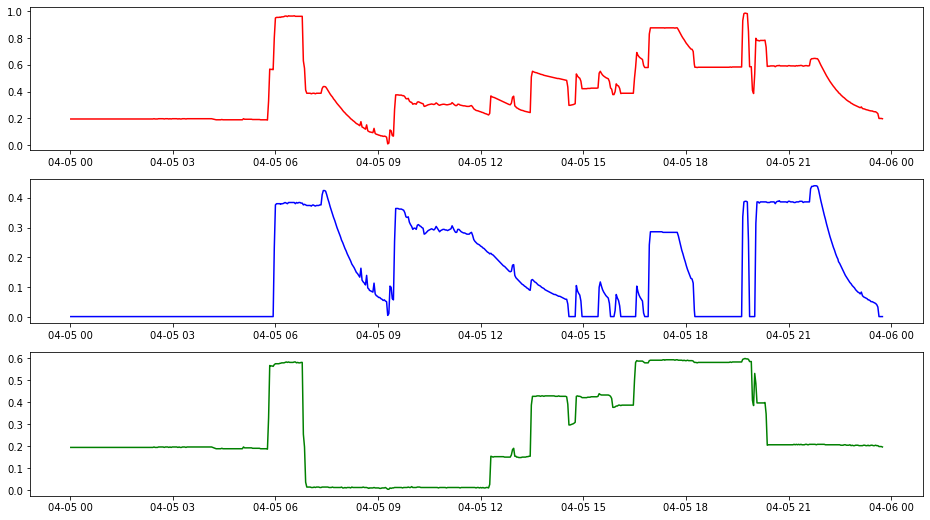

In [48]:
plt.rcParams['figure.figsize'] = [16, 9]
xtick_locator = AutoDateLocator()
xtick_formatter = AutoDateFormatter(xtick_locator)
fig, (ax1,ax2,ax3) = plt.subplots(3)
# start_pidx = 0 
dur_time = 24*30
ind1,ind2,ind3 = 1,1,1
begin1 = int(index_list[ind1])
begin2 = int(index_list[ind2])
begin3 = int(index_list[ind3])


dates1 = matplotlib.dates.date2num(all_samples[ind1].loc[begin1 : begin1+dur_time, "timestamp"])
current1 = all_samples[ind1].loc[begin1 : begin1+dur_time, "current_out"].values

dates2 = matplotlib.dates.date2num(all_samples[ind2].loc[begin2 : begin2+dur_time, "timestamp"])
current2 = all_samples[ind2].loc[begin2 : begin2+dur_time, "usb_current"].values

dates3 = matplotlib.dates.date2num(all_samples[ind3].loc[begin3 : begin3+dur_time, "timestamp"])
current3 = all_samples[ind3].loc[begin3 : begin3+dur_time, "current_in"].values

ax1.plot(dates1,current1,'r',label='0')
ax2.plot(dates2,current2,'b',label='10')
ax3.plot(dates3,current1-current2,'g',label='100')

ax1.xaxis.set_major_locator(xtick_locator)
ax1.xaxis.set_major_formatter(xtick_formatter)

ax2.xaxis.set_major_locator(xtick_locator)
ax2.xaxis.set_major_formatter(xtick_formatter)

ax3.xaxis.set_major_locator(xtick_locator)
ax3.xaxis.set_major_formatter(xtick_formatter)

In [67]:
index_list = pd.read_csv('index_4_5_2021.csv',index_col=0).values
dur_time = 1*24*30
week_all_data = []

for i,index in enumerate(index_list):
    index = int(index)
    curr_data = all_samples[i].loc[index:index+dur_time,'usb_current'].values
    week_all_data.append(curr_data)

week_all_data = np.asarray(week_all_data)

In [77]:
from tslearn.clustering import TimeSeriesKMeans

km = TimeSeriesKMeans(n_clusters=5, metric="euclidean", max_iter=50,
                        random_state=1).fit(week_all_data)

y_pred = km.predict(week_all_data)
index0 = int(index_list[0])
(uniques,counts) = np.unique(y_pred, return_counts=True)
date_time =  all_samples[0].loc[index0:index0+dur_time,'timestamp']

C:\Users\sann7383\Anaconda3\envs\pytorchAI\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 199 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


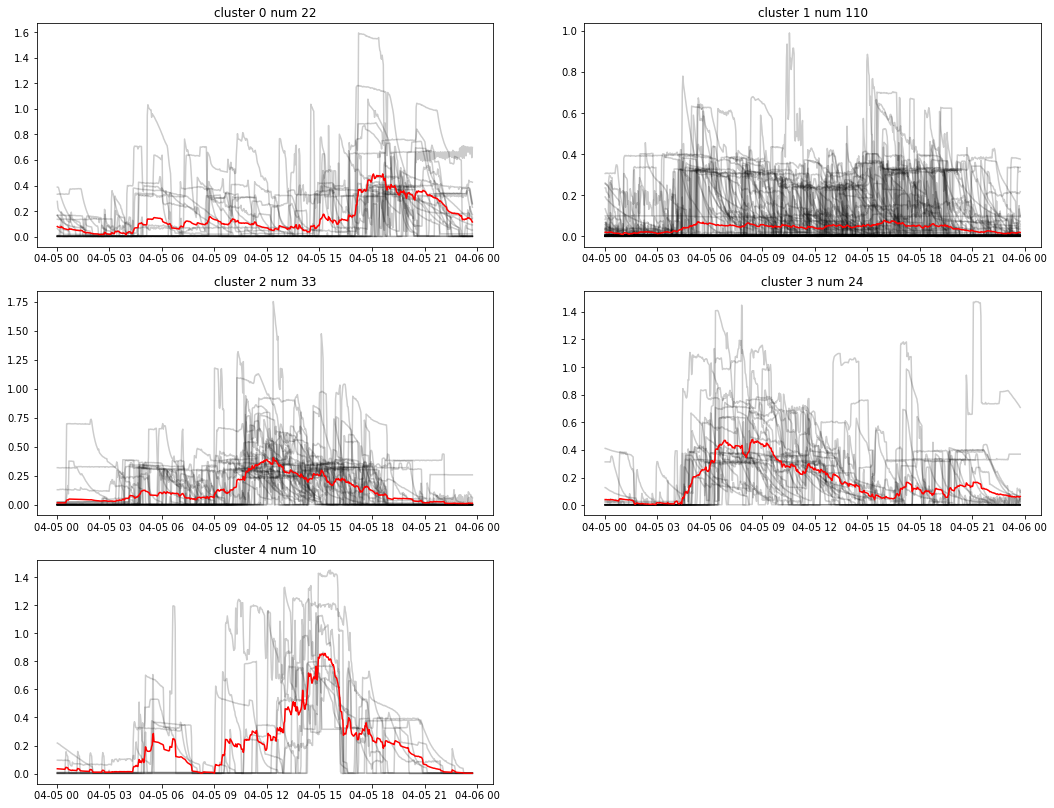

In [78]:
plt.rcParams['figure.figsize'] = [18, 14]
for yi in range(5):
    plt.subplot(3, 2, yi + 1)
    for xx in week_all_data[y_pred == yi]: 
        plt.plot_date(date_time,xx.ravel(), "k-", alpha=.2)
    plt.plot_date(date_time,km.cluster_centers_[yi].ravel(), "r-")
    plt.title('cluster '+str(yi)+' num '+str(counts[yi]))